In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use("default")


In [28]:
DATA_PATH = "master_dataset.csv"
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (71996, 9)


,label,num_processes,cpu_percent,memory_percent,disk_percent,total_allocated,total_need,deadlock_risk,source
0,SAFE,15,15.4,59.1,9.7,173,258,0.0,real_collection
1,SAFE,15,7.7,59.5,9.7,174,251,0.0,real_collection
2,SAFE,15,3.6,59.1,9.7,171,252,0.0,real_collection
3,SAFE,15,4.4,58.5,9.7,172,234,0.0,real_collection
4,SAFE,15,6.7,58.7,9.7,169,259,0.0,real_collection


In [29]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71996 entries, 0 to 71995
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   label            71996 non-null  object 
 1   num_processes    71996 non-null  int64  
 2   cpu_percent      71996 non-null  float64
 3   memory_percent   71996 non-null  float64
 4   disk_percent     71996 non-null  float64
 5   total_allocated  71996 non-null  int64  
 6   total_need       71996 non-null  int64  
 7   deadlock_risk    71996 non-null  float64
 8   source           71996 non-null  object 
dtypes: float64(4), int64(3), object(2)
memory usage: 4.9+ MB


In [30]:
df["label"].value_counts()


label
SAFE        71631
UNSAFE        357
DEADLOCK        8
Name: count, dtype: int64

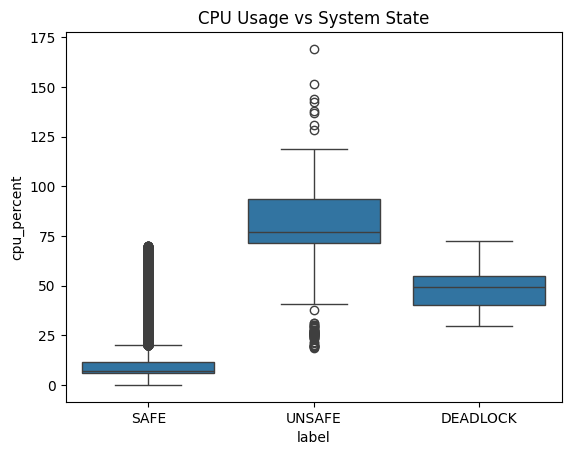

In [31]:
plt.figure()
sns.boxplot(x="label", y="cpu_percent", data=df)
plt.title("CPU Usage vs System State")
plt.savefig("cpu_vs_label.png")
plt.show()

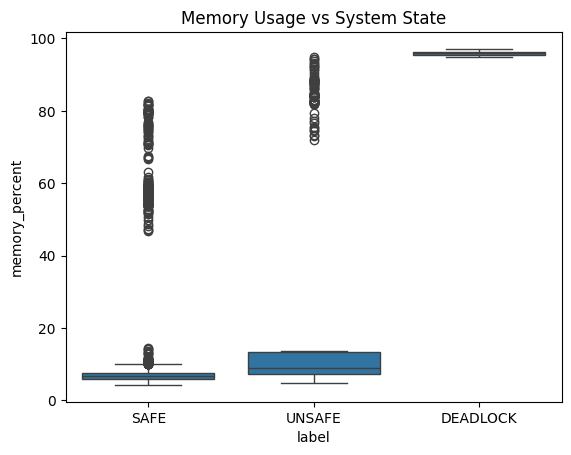

In [32]:
plt.figure()
sns.boxplot(x="label", y="memory_percent", data=df)
plt.title("Memory Usage vs System State")
plt.savefig("memory_vs_label.png")
plt.show()

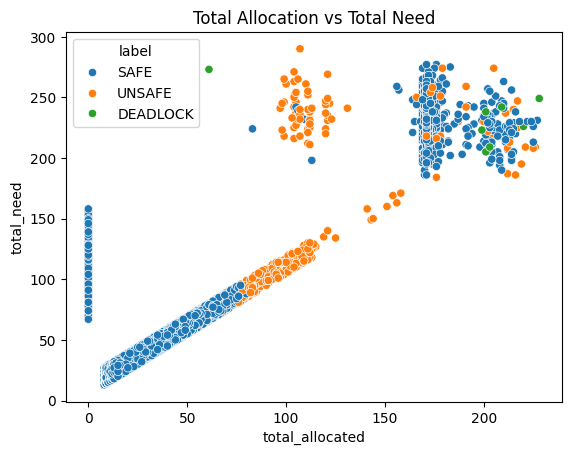

In [33]:
plt.figure()
sns.scatterplot(
    x="total_allocated",
    y="total_need",
    hue="label",
    data=df
)
plt.title("Total Allocation vs Total Need")
plt.savefig("allocation_vs_need.png")
plt.show()

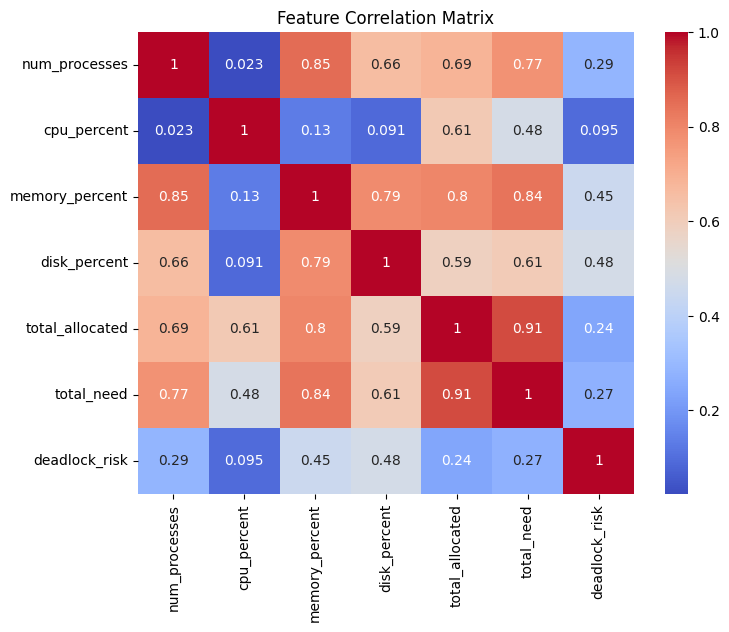

In [34]:
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


In [35]:
df = df.sort_index()

numeric_cols = ["cpu_percent", "memory_percent", "disk_percent", "total_allocated", "total_need"]
for col in numeric_cols:
    df[f"{col}_mean"] = df[col].rolling(window=5).mean()
    df[f"{col}_std"] = df[col].rolling(window=5).std()
df.dropna(inplace=True)

print("After temporal features:", df.shape)


After temporal features: (71992, 19)


In [36]:
label_map = {"DEADLOCK": 0, "SAFE": 1, "UNSAFE": 2}
df["label_encoded"] = df["label"].map(label_map)

X = df.drop(columns=["label", "label_encoded", "source", "deadlock_risk"])
y = df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [37]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [38]:
y_pred = model.predict(X_test)

print(classification_report(
    y_test, y_pred,
    target_names=label_map.keys()
))


              precision    recall  f1-score   support

    DEADLOCK       1.00      0.50      0.67         2
        SAFE       1.00      1.00      1.00     17907
      UNSAFE       0.99      0.97      0.98        89

    accuracy                           1.00     17998
   macro avg       1.00      0.82      0.88     17998
weighted avg       1.00      1.00      1.00     17998



In [39]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)


total_allocated         0.168838
memory_percent          0.168118
total_need              0.142676
total_allocated_std     0.127225
total_allocated_mean    0.083079
cpu_percent             0.077645
disk_percent_std        0.054205
total_need_mean         0.039409
memory_percent_std      0.034307
cpu_percent_mean        0.029224
dtype: float64

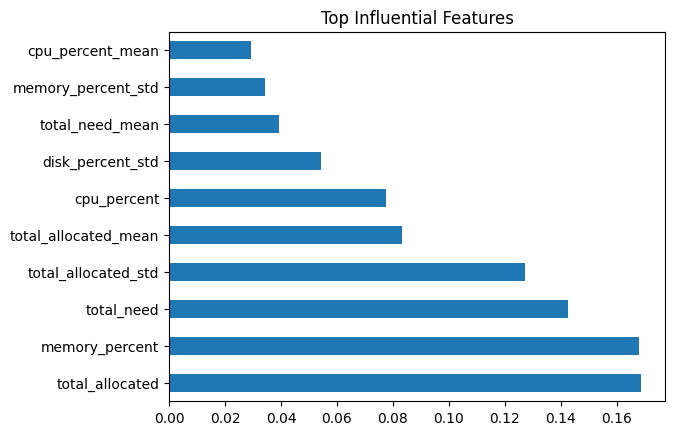

In [40]:
importances.sort_values(ascending=False).head(10).plot(kind="barh")
plt.title("Top Influential Features")
plt.show()


              precision    recall  f1-score   support

    DEADLOCK       1.00      0.50      0.67         2
        SAFE       1.00      1.00      1.00     17907
      UNSAFE       0.99      0.97      0.98        89

    accuracy                           1.00     17998
   macro avg       1.00      0.82      0.88     17998
weighted avg       1.00      1.00      1.00     17998



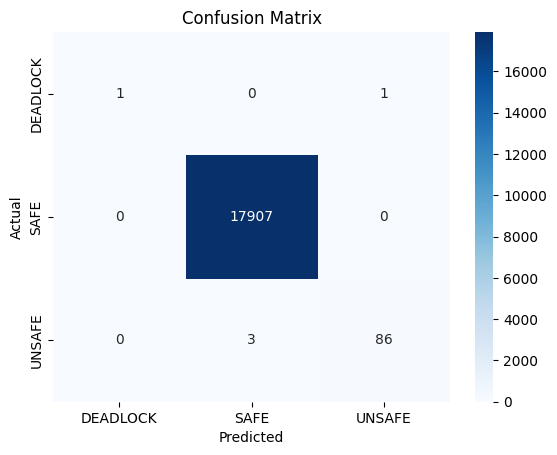

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys(), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


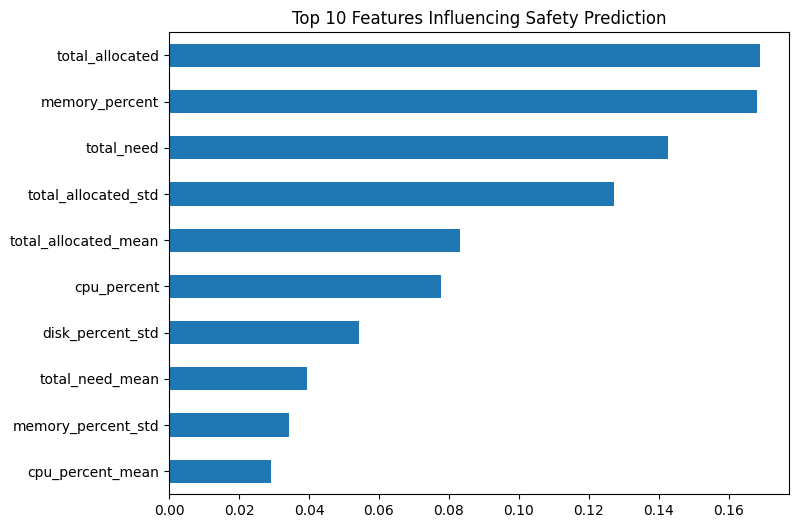

In [42]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.head(10).plot(kind="barh")
plt.title("Top 10 Features Influencing Safety Prediction")
plt.gca().invert_yaxis()
plt.show()


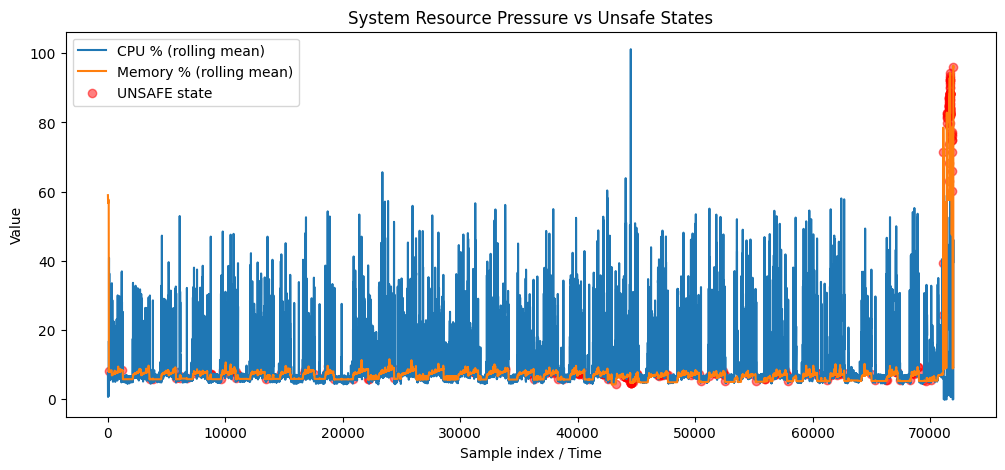

In [43]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["cpu_percent_mean"], label="CPU % (rolling mean)")
plt.plot(df.index, df["memory_percent_mean"], label="Memory % (rolling mean)")
plt.scatter(df.index[df["label"]=="UNSAFE"], df["memory_percent_mean"][df["label"]=="UNSAFE"], 
            color='red', label="UNSAFE state", alpha=0.5)
plt.xlabel("Sample index / Time")
plt.ylabel("Value")
plt.title("System Resource Pressure vs Unsafe States")
plt.legend()
plt.show()

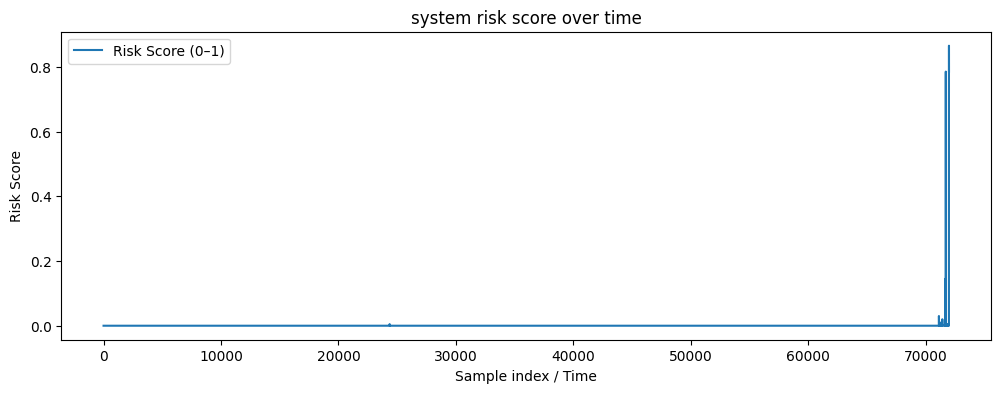

In [44]:
# Predict probabilities for each class
risk_probs = model.predict_proba(X)

# risk_score = P(DEADLOCK) + P(UNSAFE)   (index 0 + index 2)
df["risk_score"] = risk_probs[:, label_map["DEADLOCK"]]


# Plot risk_score over time
plt.figure(figsize=(12,4))
plt.plot(df.index, df["risk_score"], label="Risk Score (0–1)")
plt.xlabel("Sample index / Time")
plt.ylabel("Risk Score")
plt.title("system risk score over time")
plt.legend()
plt.show()


In [45]:
deadlock_test = df[df["label"]=="DEADLOCK"]

# Use the same feature columns as training
X_deadlock = deadlock_test[X.columns]  # X.columns = training feature names

print("Deadlock samples:", deadlock_test.shape[0])
print("Predicted:", model.predict(X_deadlock))


Deadlock samples: 8
Predicted: [0 0 0 0 0 0 2 0]


In [46]:
y_deadlock_proba = model.predict_proba(X_deadlock)
print("Predicted probabilities:\n", y_deadlock_proba)


Predicted probabilities:
 [[0.775      0.04001971 0.18498029]
 [0.785      0.02003373 0.19496627]
 [0.865      0.065      0.07      ]
 [0.67       0.205      0.125     ]
 [0.865      0.08       0.055     ]
 [0.865      0.05501244 0.07998756]
 [0.355      0.15019885 0.49480115]
 [0.785      0.18       0.035     ]]


Critical rows: 365


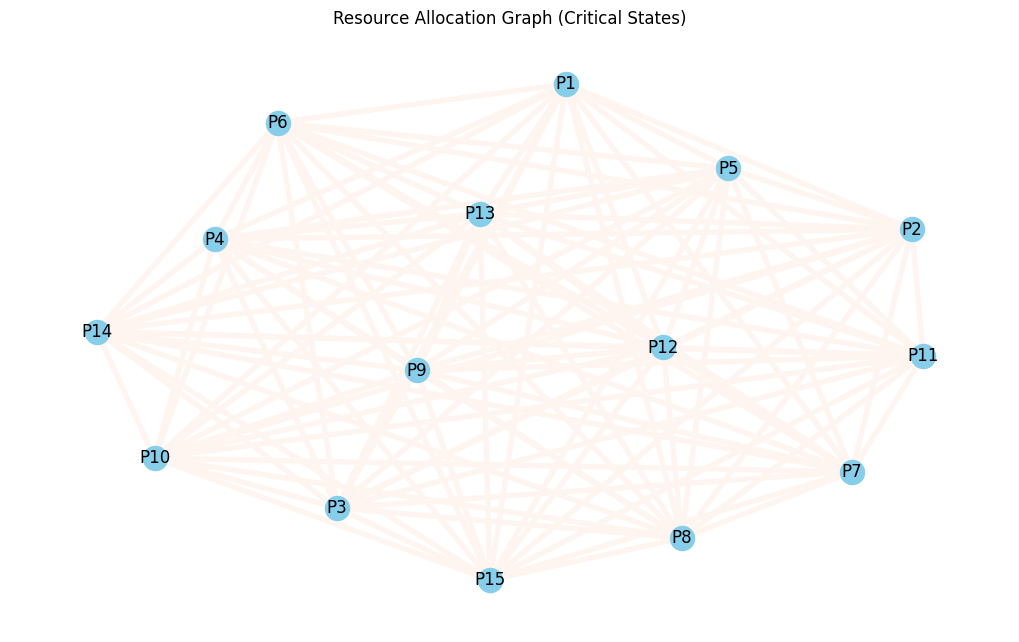

In [47]:
# %% RESOURCE ALLOCATION GRAPH
import networkx as nx

# Use UNSAFE + DEADLOCK states
critical_df = df[df["label"].isin(["UNSAFE", "DEADLOCK"])]

print("Critical rows:", critical_df.shape[0])

G = nx.Graph()

# Add nodes from max processes
max_p = critical_df["num_processes"].max()
for p in range(1, max_p + 1):
    G.add_node(f"P{p}")

# Add edges with minimum thickness
for i, row in critical_df.iterrows():
    num_proc = int(row["num_processes"])
    for p1 in range(1, num_proc + 1):
        for p2 in range(p1 + 1, num_proc + 1):
            G.add_edge(f"P{p1}", f"P{p2}", weight=row["risk_score"])

# Draw
plt.figure(figsize=(10,6))
pos = nx.spring_layout(G, seed=42)

edges = G.edges()
weights = [max(0.2, G[u][v]["weight"] * 5) for u, v in edges]

nx.draw(
    G, pos,
    with_labels=True,
    width=weights,
    edge_color=weights,
    edge_cmap=plt.cm.Reds,
    node_color='skyblue'
)

plt.title("Resource Allocation Graph (Critical States)")
plt.show()


In [48]:
import joblib
joblib.dump(model, "rf_model.joblib")


['rf_model.joblib']

In [49]:
from sklearn.ensemble import RandomForestClassifier
import joblib

live_features = [
    "num_processes",
    "cpu_percent",
    "memory_percent",
    "disk_percent",
    "total_allocated",
    "total_need"
]


X_live = df[live_features]
y_live = df["label_encoded"]

model_live = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight="balanced",
    random_state=42
)

X_live = df[live_features]
model_live.fit(X_live, y_live)

joblib.dump(model_live, "rf_model_live.joblib")
print("Live inference model saved")


Live inference model saved


In [50]:
model = joblib.load("rf_model_live.joblib")


In [51]:
# %% LIVE INFERENCE WITH SAFE / UNSAFE PERCENTAGE
import psutil
import pandas as pd
import joblib

# 1. Load the trained live-inference model
model = joblib.load("rf_model_live.joblib")

# 2. Collect live system metrics
cpu = psutil.cpu_percent(interval=1)
memory = psutil.virtual_memory().percent
disk = psutil.disk_usage("/").percent
num_proc = len(psutil.pids())

# 3. Compute resource-allocation features
total_allocated = cpu + memory
total_need = max(0, 200 - total_allocated)

# 4. Build input feature vector (same features as model)
X_live = pd.DataFrame([{
    "num_processes": num_proc,
    "cpu_percent": cpu,
    "memory_percent": memory,
    "disk_percent": disk,
    "total_allocated": total_allocated,
    "total_need": total_need
}])

# 5. Perform inference
pred_class = model.predict(X_live)[0]           # predicted class
proba = model.predict_proba(X_live)[0]          # probability for each class

# 6. Map label indices to names
labels = {0: "HIGH-RISK(DEADLOCK-PRONE)", 1: "SAFE", 2: "UNSAFE"}

# 7. Compute SAFE / UNSAFE percentages
safe_percent = round(proba[label_map["SAFE"]] * 100, 2)
unsafe_percent = round(proba[label_map["UNSAFE"]] * 100, 2)

# 8. Display results
print("LIVE SYSTEM METRICS:")
display(X_live)

print(f"PREDICTED SYSTEM STATE: {labels[pred_class]}")
print(f"Probability of SAFE: {safe_percent}%")
print(f"Probability of UNSAFE: {unsafe_percent}%")


LIVE SYSTEM METRICS:


,num_processes,cpu_percent,memory_percent,disk_percent,total_allocated,total_need
0,376,32.6,92.7,52.4,125.3,74.7


PREDICTED SYSTEM STATE: SAFE
Probability of SAFE: 69.0%
Probability of UNSAFE: 28.0%
